In [1]:
# Import required packages
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
from tqdm import trange
from paik.solver import Solver
from paik.settings import (
    DEFAULT_NSF,
    DEFULT_SOLVER,
)

In [2]:
WORKDIR = "/home/luca/paik"

solver_param = DEFULT_SOLVER
solver_param.workdir = WORKDIR
solver = Solver(solver_param=solver_param)

num_seeds = 2000
num_sols = num_seeds
num_poses = 1000
base_stds = np.arange(0.1, 1.5, 0.1)  # start, stop, step

WorldModel::LoadRobot: /home/luca/.cache/jrl/temp_urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link4.dae (43520 verts, 14620 tris)
LoadAssimp: Loaded model /ho

In [3]:
def get_numerical_ik_sols(target_pose, num_seeds):
    seeds, _ = solver._robot.sample_joint_angles_and_poses(
        n=num_seeds, return_torch=False
    )
    numer_ik = np.empty((num_seeds, solver.n))
    for i in range(num_seeds):
        numer_ik[i] = solver.robot.inverse_kinematics_klampt(
            pose=target_pose, seed=seeds[i]
        )
    return numer_ik


_, P = solver._robot.sample_joint_angles_and_poses(n=num_poses, return_torch=False)

J_ground_truth = np.empty((num_poses, num_sols, solver.n))
for i in trange(num_poses):
    J_ground_truth[i] = get_numerical_ik_sols(P[i], num_seeds)

100%|██████████| 1000/1000 [20:33<00:00,  1.23s/it]


100%|██████████| 500/500 [02:08<00:00,  3.90it/s]


mmd: 0.20381544530391693


100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


mmd: 0.18146497011184692


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


mmd: 0.1627272665500641


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


mmd: 0.14633819460868835


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


mmd: 0.1332990676164627


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


mmd: 0.12331531941890717


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


mmd: 0.11500590294599533


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


mmd: 0.10948844999074936


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


mmd: 0.1057785302400589


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


mmd: 0.10359544306993484


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


mmd: 0.10253693908452988


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


mmd: 0.10343199223279953


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


mmd: 0.1057605966925621


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


mmd: 0.10947722941637039


,l2,ang,mmd,std
count,14.000000,14.000000,14.000000,14.00000
mean,0.007808,0.064177,0.129003,0.75000
std,0.007191,0.041445,0.032670,0.41833
min,0.003200,0.030182,0.102537,0.10000
25%,0.003502,0.034760,0.105765,0.42500
50%,0.004528,0.047258,0.112247,0.75000
75%,0.008232,0.076995,0.143078,1.07500
max,0.027655,0.166607,0.203815,1.40000


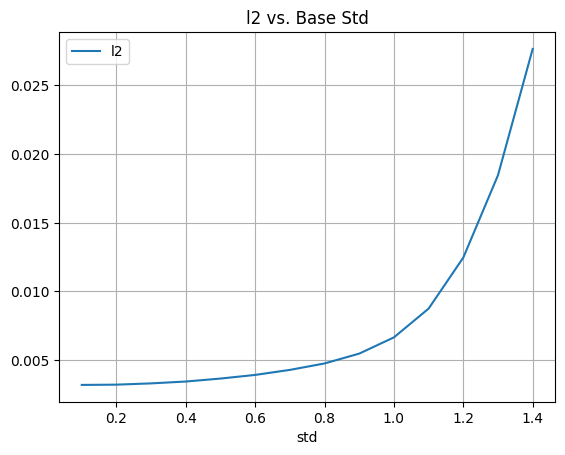

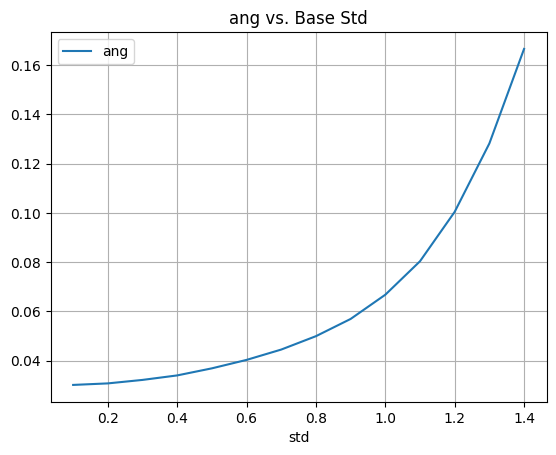

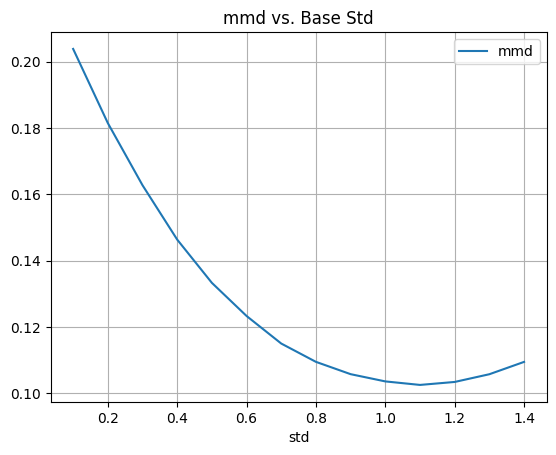

In [4]:
from example.mmd import mmd_evaluate_multiple_poses

l2_mean = np.empty((len(base_stds)))
ang_mean = np.empty((len(base_stds)))
mmd_mean = np.empty((len(base_stds)))

for i, std in enumerate(base_stds):
    solver.base_std = std
    P_expand_dim = np.expand_dims(P, axis=1).repeat(num_sols, axis=1).reshape(-1, P.shape[-1])

    F = solver.F[
        solver.P_knn.kneighbors(
            np.atleast_2d(P), n_neighbors=num_sols, return_distance=False
        ).flatten()
    ]
    J_hat = solver.solve_batch(P_expand_dim, F, 1)
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_hat, P_expand_dim, return_all=True)
    J_hat = J_hat.reshape(num_poses, num_sols, -1)
    l2_mean[i] = l2.mean()
    ang_mean[i] = ang.mean()
    mmd_mean[i] = mmd_evaluate_multiple_poses(
        J_hat, J_ground_truth, num_poses=num_poses
    )
    assert not np.isnan(mmd_mean[i])

df = pd.DataFrame({"l2": l2_mean, "ang": ang_mean, "mmd": mmd_mean, "std": base_stds})
df.plot(x="std", y=["l2"], title="l2 vs. Base Std", grid=True)
df.plot(x="std", y=["ang"], title="ang vs. Base Std", grid=True)
df.plot(x="std", y=["mmd"], title="mmd vs. Base Std", grid=True)
df.describe()

config.py: Using device 'cuda:0'
set_seed() - random int:  541
WorldModel::LoadRobot: /tmp/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual

,l2,ang,mmd,std
count,14.000000,14.000000,14.000000,14.00000
mean,0.007538,0.044772,0.401232,0.75000
std,0.002242,0.008404,0.437781,0.41833
min,0.005170,0.036601,0.125095,0.10000
25%,0.005718,0.038079,0.130712,0.42500
50%,0.006908,0.041766,0.193757,0.75000
75%,0.008886,0.049856,0.450984,1.07500
max,0.012091,0.062149,1.612937,1.40000


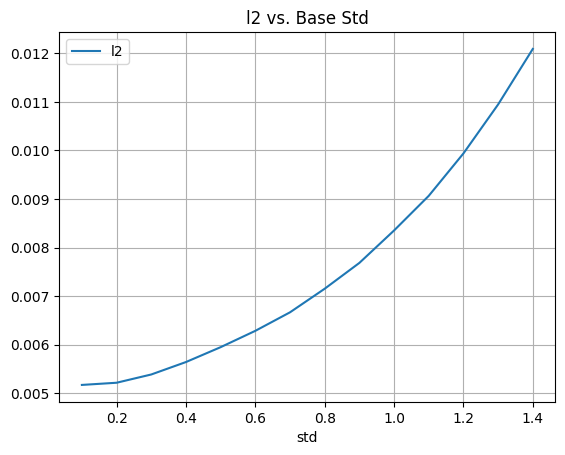

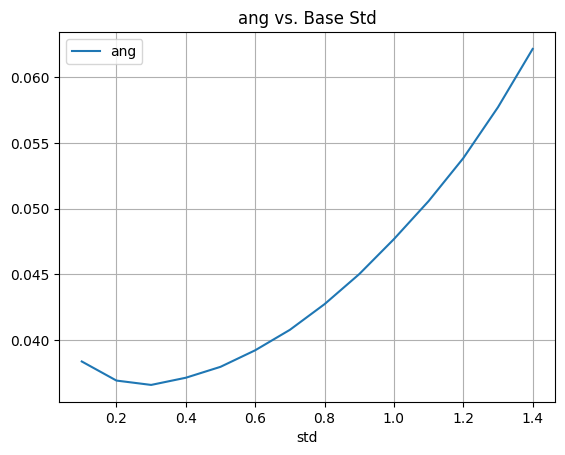

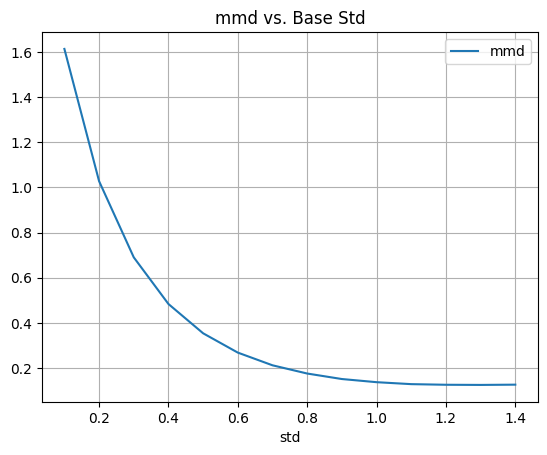

In [5]:
from ikflow.utils import set_seed
from ikflow.model_loading import get_ik_solver

set_seed()
# Build IKFlowSolver and set weights
ik_solver, _ = get_ik_solver("panda__full__lp191_5.25m")
l2_flow = np.empty((len(base_stds)))
ang_flow = np.empty((len(base_stds)))
mmd_flow = np.empty((len(base_stds)))

for i, std in enumerate(base_stds):
    J_flow = np.array(
        [ik_solver.solve(p, n=num_sols, latent_scale=std).cpu().numpy() for p in P]
    )
    J_flow = J_flow.transpose(1, 0, 2)  # (num_sols, num_poses, n)
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_flow, P, return_all=True)
    l2_flow[i] = l2.mean()
    ang_flow[i] = ang.mean()
    mmd_flow[i] = mmd_evaluate_multiple_poses(
        J_flow.transpose(1, 0, 2), J_ground_truth, num_poses=num_poses
    )


df_flow = pd.DataFrame(
    {"l2": l2_flow, "ang": ang_flow, "mmd": mmd_flow, "std": base_stds}
)
df_flow.plot(x="std", y=["l2"], title="l2 vs. Base Std", grid=True)
df_flow.plot(x="std", y=["ang"], title="ang vs. Base Std", grid=True)
df_flow.plot(x="std", y=["mmd"], title="mmd vs. Base Std", grid=True)
df_flow.describe()

<AxesSubplot: title={'center': 'mmd vs. Base Std'}, xlabel='std'>

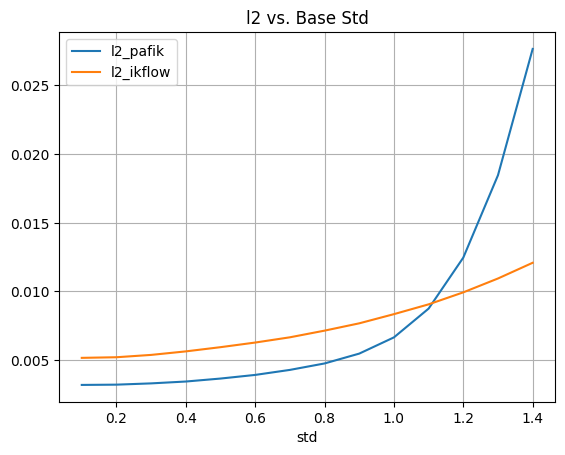

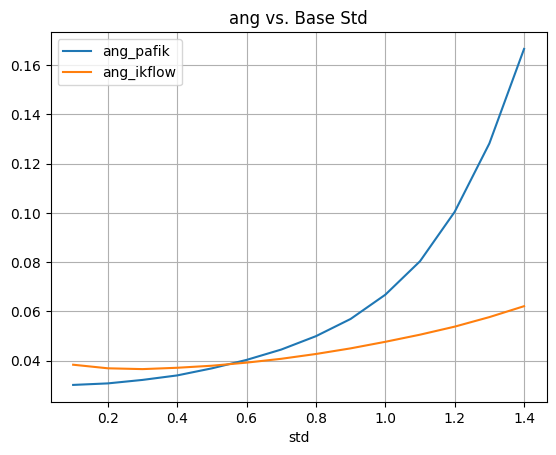

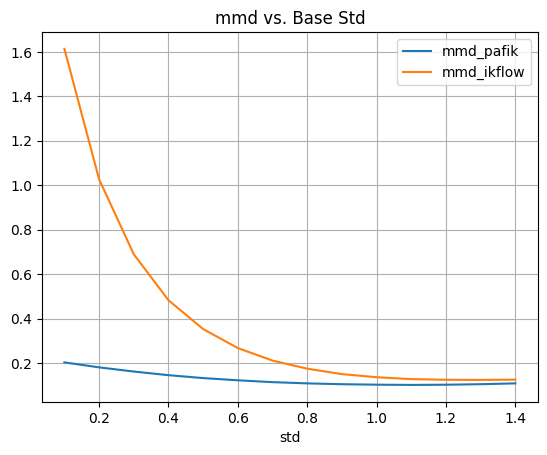

In [6]:
df_l2 = pd.DataFrame({"l2_paik": l2_mean, "l2_ikflow": l2_flow, "std": base_stds})
df_ang = pd.DataFrame({"ang_paik": ang_mean, "ang_ikflow": ang_flow, "std": base_stds})
df_mmd = pd.DataFrame({"mmd_paik": mmd_mean, "mmd_ikflow": mmd_flow, "std": base_stds})

df_l2.plot(x="std", y=["l2_paik", "l2_ikflow"], title="l2 vs. Base Std", grid=True)
df_ang.plot(x="std", y=["ang_paik", "ang_ikflow"], title="ang vs. Base Std", grid=True)
df_mmd.plot(x="std", y=["mmd_paik", "mmd_ikflow"], title="mmd vs. Base Std", grid=True)

In [10]:
import os
from datetime import datetime

record_dir = f"{WORKDIR}/record/{datetime.today().strftime('%Y_%m_%d')}"
os.makedirs(record_dir, exist_ok=True)
df.to_pickle(f"{record_dir}/paik_posture_mmd_std.pkl")
df_flow.to_pickle(f"{record_dir}/ikflow_posture_mmd_std.pkl")